# E-tivity 2: Clustering and Manifold Learning

This notebook demonstrates:
- the k-Means clustering algorithm
- the use of manifold-learning techniques to project a clustered dataset into a 2D space and visualise it as a scatterplot

### A. Import Python Modules and Dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import manifold #needed for multidimensional scaling (MDS) and t-SNE
from sklearn import cluster #needed for k-Means clustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, FunctionTransformer, OneHotEncoder #needed for data preparation

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config

#### Load the dataset

In [3]:
df = pd.read_csv("./bank.csv")
print('(number of examples, number of attributes): ', df.shape)

(number of examples, number of attributes):  (2000, 17)


### B. Exploratory Data Analysis and Data Preparation

In [4]:
df.head()

age          job   marital  education default  balance housing loan  \
0  32.0   technician    single   tertiary      no      392     yes   no   
1  39.0   technician  divorced  secondary      no      688     yes  yes   
2  59.0      retired   married  secondary      no     1035     yes  yes   
3  47.0  blue-collar   married  secondary      no      398     yes  yes   
4  54.0      retired   married  secondary      no     1004     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome  \
0  cellular    1   apr       957         2    131         2  failure   
1  cellular    1   apr       233         2    133         1  failure   
2  cellular    1   apr       126         2    239         1  failure   
3  cellular    1   apr       274         1    238         2  failure   
4  cellular    1   apr       479         1    307         1  failure   

  subscribed  
0         no  
1         no  
2         no  
3         no  
4         no

In [5]:
df.tail()

age           job  marital  education default  balance housing loan  \
1995  20.0       student   single        NaN      no     2785      no   no   
1996  28.0        admin.   single  secondary      no      127      no   no   
1997  81.0       retired  married    primary      no     1154      no   no   
1998  46.0      services  married    primary      no     4343     yes   no   
1999  40.0  entrepreneur  married  secondary      no     6403      no   no   

        contact  day month  duration  campaign  pdays  previous poutcome  \
1995   cellular   16   sep       327         2     -1         0      NaN   
1996   cellular   16   sep      1334         2     -1         0      NaN   
1997  telephone   17   sep       231         1     -1         0      NaN   
1998        NaN   20   sep       185         1     -1         0      NaN   
1999   cellular   22   sep       208         2     -1         0      NaN   

     subscribed  
1995        yes  
1996        yes  
1997        yes  
1998        yes  
1999        yes

In [6]:
df.describe()

age       balance          day     duration     campaign  \
count  1988.000000   2000.000000  2000.000000  2000.000000  2000.000000   
mean     41.753018   1413.663500    13.851500   292.020500     1.909500   
std      12.724358   3131.224213     9.712189   221.557295     1.378862   
min      18.000000   -980.000000     1.000000     7.000000     1.000000   
25%      32.000000    201.500000     5.000000   146.000000     1.000000   
50%      38.000000    551.000000    12.000000   236.000000     1.000000   
75%      50.000000   1644.500000    23.000000   379.000000     2.000000   
max      93.000000  81204.000000    31.000000  1823.000000    11.000000   

             pdays     previous  
count  2000.000000  2000.000000  
mean    167.896000     2.561500  
std     131.754126     3.400735  
min      -1.000000     0.000000  
25%      75.750000     1.000000  
50%     182.000000     2.000000  
75%     251.000000     3.000000  
max     854.000000    55.000000

The dataset consists of 2000 data rows 

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'balance'}>,
        <Axes: title={'center': 'day'}>],
       [<Axes: title={'center': 'duration'}>,
        <Axes: title={'center': 'campaign'}>,
        <Axes: title={'center': 'pdays'}>],
       [<Axes: title={'center': 'previous'}>, <Axes: >, <Axes: >]],
      dtype=object)

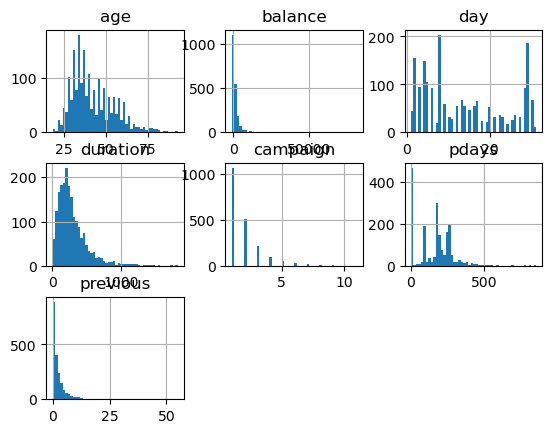

In [8]:
df.hist(bins=50)

<Axes: >

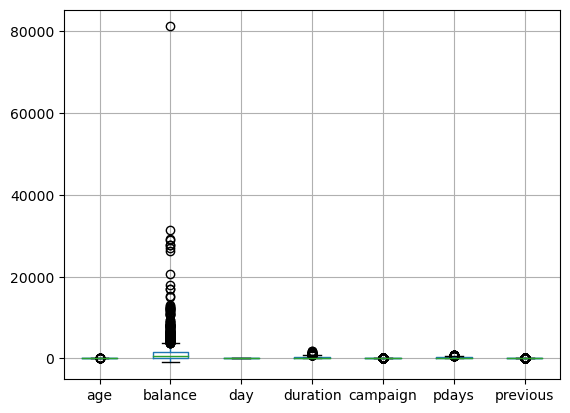

In [9]:
df.boxplot()

In [10]:
# Create a mapper

scale_mapper = {
    "primary": 1,
    "secondary": 2,
    "tertiary": 3
}

df['education'] = df['education'].replace(scale_mapper)
df.tail()

age           job  marital  education default  balance housing loan  \
1995  20.0       student   single        NaN      no     2785      no   no   
1996  28.0        admin.   single        2.0      no      127      no   no   
1997  81.0       retired  married        1.0      no     1154      no   no   
1998  46.0      services  married        1.0      no     4343     yes   no   
1999  40.0  entrepreneur  married        2.0      no     6403      no   no   

        contact  day month  duration  campaign  pdays  previous poutcome  \
1995   cellular   16   sep       327         2     -1         0      NaN   
1996   cellular   16   sep      1334         2     -1         0      NaN   
1997  telephone   17   sep       231         1     -1         0      NaN   
1998        NaN   20   sep       185         1     -1         0      NaN   
1999   cellular   22   sep       208         2     -1         0      NaN   

     subscribed  
1995        yes  
1996        yes  
1997        yes  
1998        yes  
1999        yes

In [11]:
df.dropna(inplace=True)

In [12]:
# First, we define a pipeline consisting of two transforms, applied to the petallength and petalwidth columns in a sequence.
# Next, we use ColumnTransformer to construct the main preprocessing pipeline which consists of all data preprocessing steps applied to all columns.
preprocess_pipeline = ColumnTransformer(
    transformers = [
        ("numeric", RobustScaler(), ["age","balance","day","duration","campaign","pdays","previous"]),    # preprocessing of sepallength
        ("categorical", OneHotEncoder(dtype='int'), ["job","marital","default","housing","loan","contact","month","poutcome","subscribed"])         # preprocessing of sepalwidth
    ]
)

### C. Scatterplot Function (to be used below for visualising a clustering)

Skip this section when you read the notebook for the first time.

The function `clustering_scatterplot()` creates the 2D scatter plot of the clustered dataset.

In [13]:
colors = np.array(['orange', 'blue', 'lime', 'khaki', 'pink', 'green', 'purple'])

# points - a 2D array of (x,y) coordinates of data points
# labels - an array of numeric labels in the interval [0..k-1], one for each point
# centers - a 2D array of (x, y) coordinates of cluster centers
# title - title of the plot


def clustering_scatterplot(points, labels, centers, title):
    
    
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1], 
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))

    # plot the centers of the clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)

    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

### D. K-Means Clustering

The k-Means clustering algorithm has the number of clusters $k$ as an input parameter __n_clusters__. We construct a final pipeline for training a k-Means clustering model for a fixed value of __n_clusters__ $=3$. The final pipeline has the preprocessing pipeline as its first step followed by the scikit-learn KMeans algorithm as a second step.

In [14]:
k = 2

pipe = Pipeline(steps=[
    ('preprocess', preprocess_pipeline), 
    ('kMeans', cluster.KMeans(n_clusters=k, n_init=10, max_iter=300))
])


Next, we fit the pipeline on the dataset to train a clustering model.

In [15]:
clustering_model = pipe.fit(df)

In [19]:
# Here we use the preprocessing step of the pipeline to get a copy of the dataset with the preprocessing steps applied to it.
preprocessed_data = clustering_model['preprocess'].transform(df)

In [17]:
clustering_model['kMeans'].inertia_

19694.51842037683